In [21]:
import geopandas as gpd
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal, osr, gdal_array
from shapely.geometry import mapping
from calendar import monthrange
from dateutil.relativedelta import relativedelta

In [13]:
def get_netcdf_info(fname, var, data):
    subset = 'NETCDF:"' + fname + '":' + var
    sub_ds = gdal.Open(subset)
    nodata = sub_ds.GetRasterBand(1).GetNoDataValue()
    xsize = sub_ds.RasterXSize
    ysize = sub_ds.RasterYSize
    geot = sub_ds.GetGeoTransform()
    proj = osr.SpatialReference()
    proj.SetWellKnownGeogCS('NAD27')
    data = data[var]
    data = np.ma.masked_array(data, mask=(data == nodata), fill_value=nodata)
    return nodata, xsize, ysize, geot, proj, data


def create_geotiff(suffix, arr, ndv, xsize, ysize, geot, proj):
    dt = gdal_array.NumericTypeCodeToGDALTypeCode(arr.dtype)
    if type(dt) != np.int:
        if dt.startswith('gdal.GDT_') is False:
            dt = eval('gdal.GDT_'+dt)
    new_fname = suffix + '.tif'
    zsize = 1
    driver = gdal.GetDriverByName('GTiff')
    arr[np.isnan(arr)] = ndv
    ds = driver.Create(new_fname, xsize, ysize, zsize, dt)
    ds.SetProjection(proj)
    ds.SetGeoTransform(geot)
    ds.GetRasterBand(1).WriteArray(arr)
    ds.GetRasterBand(1).SetNoDataValue(ndv)
    ds.FlushCache()
    return new_fname



def preprocess(img, mask):
    xds = xr.open_dataset(img,
                          decode_times=False)
    mask = xr.open_dataset(mask,
                           decode_times=False)
    dates = [pd.to_datetime('2002-01-01') + relativedelta(days=n) for n in xds['time'][:].values]
    xds = xds.isel(time=slice(None,None)).where(mask.LO_val > 0)
    lon_name = 'lon'
    xds['_longitude_adjusted'] = xr.where(xds[lon_name] > 180,
                                          xds[lon_name] - 360,
                                          xds[lon_name])
    xds = (
        xds
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(xds._longitude_adjusted)})
        .drop(lon_name))
    xds = xds.rename({'_longitude_adjusted': lon_name})
    attrs = {'standard_name': 'longitude',
             'bounds': 'lon_bounds',
             'axis': 'X',
             'standard_name': 'Longitude',
             'long_name': 'Longitude',
             'Units': 'degrees_east',
             'valid_min': '-179.875',
             'valid_max': '179.875'}
    pa = xds.lon.assign_attrs(attrs, inplace=True)
    xds = xds.assign_coords(lon=pa)
    xds.rio.write_crs("EPSG:4326", inplace=True)
    return xds, dates


def postprocess(df_list):
    dfs = pd.concat(df_list, axis=1)
    dfs = dfs.reset_index()
    dfs['days'] = dfs['index'].apply(lambda x: monthrange(x.year, x.month)[1])
    dfs = dfs.set_index('index')
    return dfs

In [14]:
xds, dates = preprocess("CSR_GRACE_GRACE-FO_RL06_Mascons_all-corrections_v02.nc",
                        'CSR_GRACE_GRACE-FO_RL06_Mascons_v02_LandMask.nc')

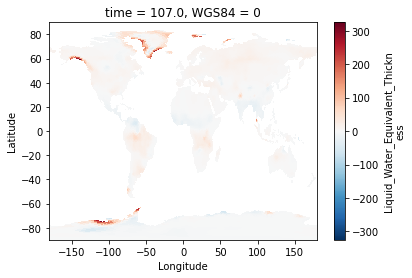

In [10]:
xds.isel(time=0)['lwe_thickness'].plot()
plt.show()

In [11]:
geodf = gpd.read_file("cuencas.shp")
cuencas = geodf['NOM_CUEN'].unique()

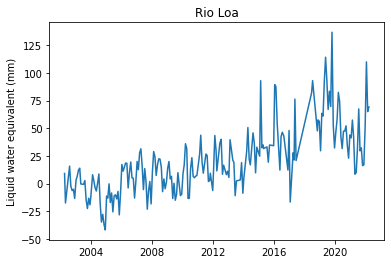

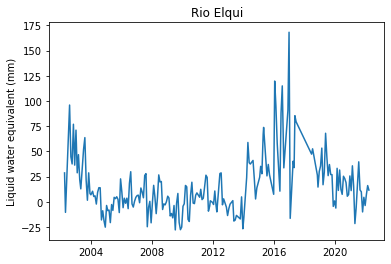

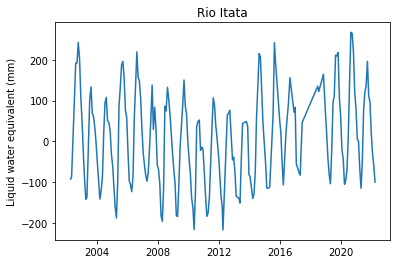

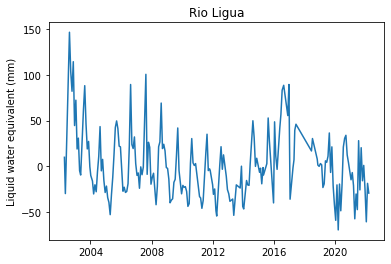

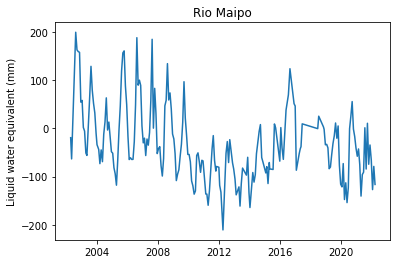

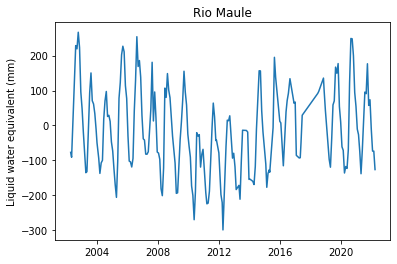

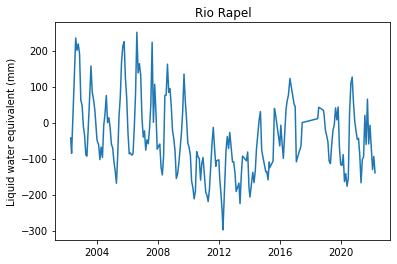

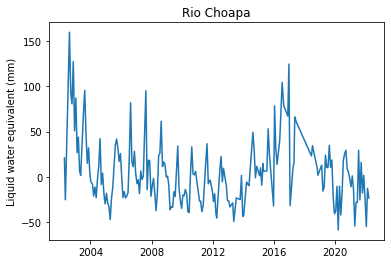

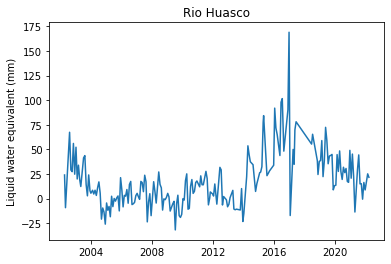

c:\Users\ignis\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\shape_base.py:495: RuntimeWarning: Mean of empty slice
  res = func(*args)


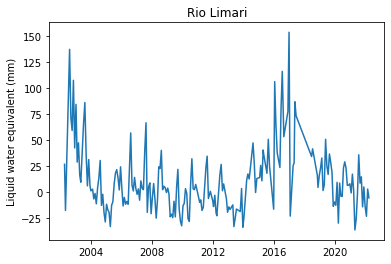

c:\Users\ignis\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\shape_base.py:495: RuntimeWarning: Mean of empty slice
  res = func(*args)


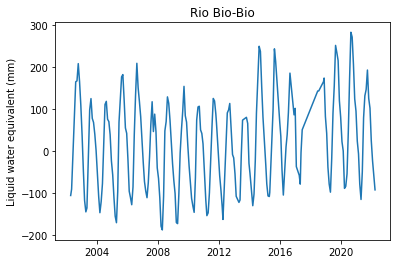

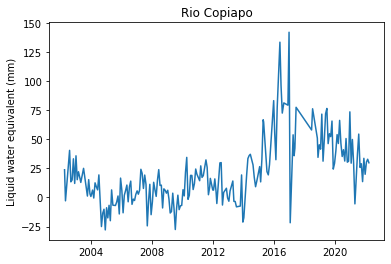

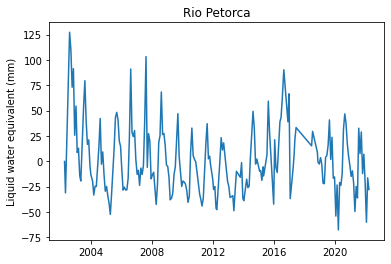

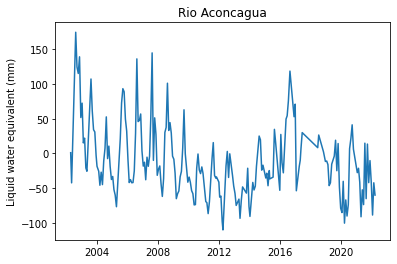

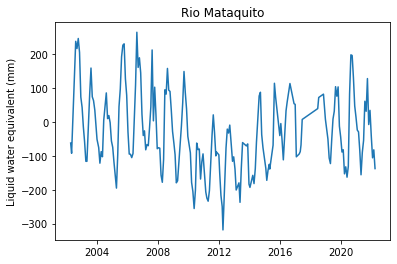

In [19]:
basins, dfs = [], []
for n in cuencas[:]:
    try:
        basins.append(n)
        sub_geo = geodf[geodf['NOM_CUEN'] == n]
        area = sub_geo.copy().to_crs({'proj': 'cea'}).geometry.area.iloc[0]
        clipped = xds['lwe_thickness'].rio.clip(sub_geo.geometry.apply(mapping),
                                                sub_geo.crs)
        data = np.apply_over_axes(np.nanmean, clipped.values, (1,2)).ravel()
        plt.plot(dates[:],
                 data * 10)
        plt.title(n)
        plt.ylabel('Liquid water equivalent (mm)')
        plt.show()
        df = pd.DataFrame(index=dates, data={'{}'.format(n):data*10})

        dfs.append(df)
    except:
        print(n)
        continue

In [ ]:
dfs = postprocess(dfs)
dfs.to_csv('grace_xxx.csv')